In [1]:
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt

# ================================
# SETTINGS
# ================================

data = "cleaned_assets_price_volume_data_6_months_no_std.csv"                 
covMat = "covariance_using_return.csv"
precisionMat = "precision_using_return.csv"

ANNUALIZE = False
PERIODS_PER_YEAR = 252

N_RANDOM = 5000
RANDOM_SEED = 42

In [2]:
# ================================
# 1) LOAD PRICES AND BUILD DAILY RETURNS
# ================================

# I load the filtered universe of assets (the one matched to the Glasso precision matrix).
# Expected columns: Date, Open, High, Low, Close, Ticker
prices_long = pd.read_csv(data)
prices_long["Date"] = pd.to_datetime(prices_long["Date"])


# Price matrix: rows = dates, columns = tickers (using Close prices)
price_df = (
    prices_long
    .pivot(index="Date", columns="Ticker", values="Close")
    .sort_index()
)

if price_df.shape[1] < 2:
    raise ValueError("Need at least two assets to run Markowitz.")

# Simple daily returns
returns = price_df.pct_change().dropna(how="any")   # pct_change do [p(t)-p(t-1)]/p(t-1)

# Print if assets with zero variance (constant returns)
const_cols = returns.columns[returns.std() == 0] 
if len(const_cols) > 0:
    print("there are some constant columns -- zero variance assets")
    print(const_cols.tolist())

tickers = returns.columns   # this df has row=dates, col=tickers
n_assets = len(tickers)
print("Number of assets in filtered universe:", n_assets)

there are some constant columns -- zero variance assets
['GPTX']
Number of assets in filtered universe: 643


In [3]:
# inspect variance free assets   # TODO: what happens if there is a risk-free asset with 0 return?
print(returns[const_cols].head())

temp = returns["GPTX"].values
print(sum(temp))

Ticker      GPTX
Date            
2024-09-13   0.0
2024-09-14   0.0
2024-09-15   0.0
2024-09-16   0.0
2024-09-17   0.0
0.0


In [4]:
# ================================
# 2) LOAD GLASSO PRECISION and COVARIANCE MATRIX
# ================================
# Theta = Σ^{-1}

Theta_daily = pd.read_csv(precisionMat, index_col=0).values
Sigma_daily = pd.read_csv(covMat, index_col=0).values

if Theta_daily.shape != (n_assets, n_assets):
    raise ValueError("Precision matrix shape does not match number of assets.")


In [5]:
# ================================
# 3) ESTIMATE MEAN VECTOR AND ANNUALIZE IF REQUESTED
# ================================

# Daily mean returns
mu_daily = returns.mean().values.astype(float)  # do the mean over rows (dates)


# Annualize if requested
if ANNUALIZE:
    mu = mu_daily * PERIODS_PER_YEAR
    Sigma = Sigma_daily * PERIODS_PER_YEAR
    Theta = Theta_daily / PERIODS_PER_YEAR  # (c * Σ)^{-1} = (1/c) Σ^{-1}
else:
    mu = mu_daily
    Sigma = Sigma_daily
    Theta = Theta_daily

In [6]:
# ================================
# 4) MARKOWITZ COEFFICIENTS AND FRONTIER (NO RISK-FREE, SHORT ALLOWED)
# ================================
# Theta = Σ^{-1}

def markowitz_coeffs(mu, Theta):
    """Compute A, B, C, D using the precision matrix Theta."""
    ones = np.ones_like(mu)
    A = ones @ Theta @ ones
    B = ones @ Theta @ mu
    C = mu   @ Theta @ mu
    D = A * C - B**2
    return A, B, C, D

A, B, C, D = markowitz_coeffs(mu, Theta)

if D <= 0:
    raise ValueError("D <= 0: something is wrong with Θ or μ.")

def min_variance_portfolio(Theta):
    """Minimum-variance portfolio under 1'w = 1, with short-selling allowed."""
    ones = np.ones(Theta.shape[0])
    A = ones @ Theta @ ones
    w_mv = Theta @ ones / A
    return w_mv

def portfolio_stats(w, mu, Sigma):
    """Compute mean and volatility of portfolio w."""
    var = float(w @ Sigma @ w)
    if var < 0:
        print("Warning: negative variance encountered in portfolio_stats.")
        var = max(var, 0.0)  # numerical safeguard
    ret = float(w @ mu)
    vol = float(np.sqrt(var))
    return ret, vol

w_mv = min_variance_portfolio(Theta)                # weights of min-variance portfolio
ret_mv, vol_mv = portfolio_stats(w_mv, mu, Sigma)   # stats of min-variance portfolio
p_mv = B / A         # theoretical mean of min-variance portfolio

print("ret_mv (from w_mv) =", ret_mv)
print("p_mv (B/A)         =", p_mv)

def efficient_frontier(mu, A, B, C, D, n_points=1000,
                       ret_min=None, ret_max=None,
                       return_full=False):
    """
    Compute the Markowitz frontier (no risk-free asset, short allowed).

    If return_full=False (default), returns only the efficient branch (p >= p_mv).
    If return_full=True, returns the whole parabola (both inefficient and efficient parts).

    ret_min / ret_max allow you to manually extend the return range.
    """
    p_mv = B / A  # mean of min-variance portfolio

    # Empirical range of asset expected returns
    mu_min_emp = mu.min()
    mu_max_emp = mu.max()

    # Choose the range for target returns
    if ret_min is None:
        # Go below both the empirical minimum and p_mv, by some margin, to allow negative returns
        span = mu_max_emp - mu_min_emp
        # For daily returns, span is small; extend by e.g. one extra span below:
        ret_min = min(mu_min_emp, p_mv) - 1.0 * span
    if ret_max is None:
        ret_max = mu_max_emp + 0.1 * (mu_max_emp - mu_min_emp)

    p_grid = np.linspace(ret_min, ret_max, n_points)

    sigma2_grid = (A * p_grid**2 - 2 * B * p_grid + C) / D
    sigma2_grid = np.maximum(sigma2_grid, 0.0)
    sigma_grid = np.sqrt(sigma2_grid)

    if return_full:
        # return the whole parabola
        return sigma_grid, p_grid, p_mv

    # only efficient branch
    mask_eff = p_grid >= p_mv
    p_eff = p_grid[mask_eff]
    sigma_eff = sigma_grid[mask_eff]
    return sigma_eff, p_eff, p_mv


# Compute full Markowitz parabola and efficient part
sigma_all, p_all, p_mv = efficient_frontier(
    mu, A, B, C, D,
    n_points=400,
    ret_min=-0.05,      # or explicitly something like -0.005 for daily returns
    ret_max=None,
    return_full=True
)

# Efficient part subset (p >= p_mv)
mask_eff = p_all >= p_mv
sigma_eff = sigma_all[mask_eff]
p_eff = p_all[mask_eff]

ret_mv (from w_mv) = 0.00034588882335975606
p_mv (B/A)         = 0.0003458888233597562


In [7]:
# ================================
# 5) RANDOM PORTFOLIOS (SHORT ALLOWED)
# ================================

def random_portfolios(mu, Sigma, n=N_RANDOM, seed=RANDOM_SEED):
    """
    Generate random portfolios with short-selling allowed.
    I sample Gaussian weights and normalize so that 1'w = 1.
    """
    rng = np.random.default_rng(seed)
    n_assets = len(mu)

    W = rng.normal(size=(n, n_assets))
    W = W / W.sum(axis=1, keepdims=True)

    rets = W @ mu
    var = np.einsum("ij,jk,ik->i", W, Sigma, W)  # equivalent to np.diag(W @ Sigma @ W.T)
    var = np.maximum(var, 0.0)
    vols = np.sqrt(var)
    
    # To make the plot cleaner
    var_threshold = np.quantile(var, 0.5)
    mask = var <= var_threshold
    W = W[mask]
    rets = rets[mask]
    vols = vols[mask]
    
    return rets, vols, W

rp_rets, rp_vols, rp_W = random_portfolios(mu, Sigma)   

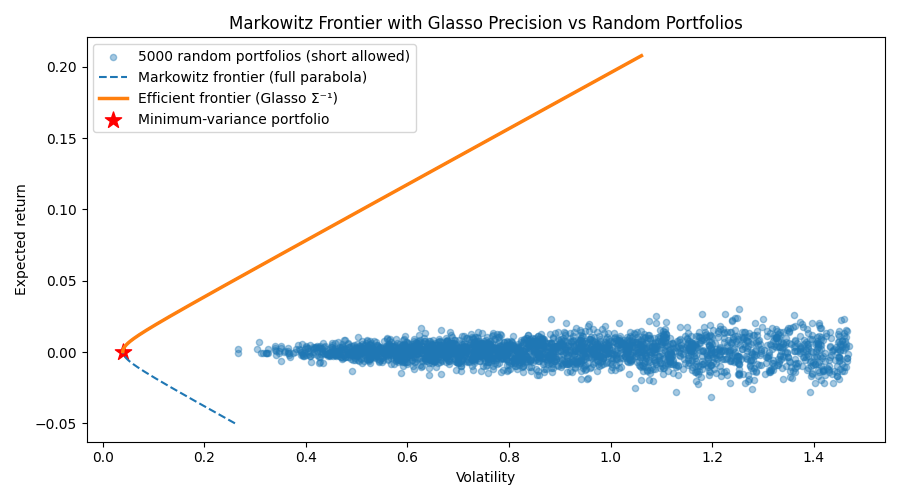

In [8]:
# ================================
# 6) PLOT RESULTS
# ================================
fig, ax = plt.subplots(figsize=(9, 5))

# Random portfolios
ax.scatter(
    rp_vols,
    rp_rets,
    s=20,
    alpha=0.4,
    label=f"{N_RANDOM} random portfolios (short allowed)"
)

# Full Markowitz parabola (inefficient + efficient)
ax.plot(
    sigma_all,
    p_all,
    lw=1.5,
    linestyle="--",
    label="Markowitz frontier (full parabola)"
)

# Efficient frontier (right branch only, highlighted)
ax.plot(
    sigma_eff,
    p_eff,
    lw=2.5,
    label="Efficient frontier (Glasso Σ⁻¹)"
)

# Minimum-variance portfolio
ax.scatter(
    [vol_mv],
    [ret_mv],
    marker="*",
    s=150,
    color="red",
    label="Minimum-variance portfolio"
)

x_label = "Volatility"
y_label = "Expected return"
if ANNUALIZE:
    x_label += " (annualized)"
    y_label += " (annualized)"

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title("Markowitz Frontier with Glasso Precision vs Random Portfolios")
ax.legend()
plt.tight_layout()
plt.show()

In [9]:
# ================================
# 7) PRINT W FOR REFERENCE
# ================================

w_mv_series = pd.Series(w_mv, index=tickers).sort_values(ascending=False)
print("\nTop 10 weights in the minimum-variance portfolio (Glasso-based):")
print(w_mv_series.head(10))
print("Sum of weights =", w_mv_series.sum())

# print return of min-variance portfolio
print("Return of min-variance portfolio =", ret_mv)


Top 10 weights in the minimum-variance portfolio (Glasso-based):
Ticker
GPTX       0.004546
OSA.BE     0.001551
TRMB       0.001551
4612.T     0.001551
TISI       0.001551
0011.HK    0.001551
NSC        0.001551
BKR        0.001551
4183.T     0.001551
ANTO.L     0.001551
dtype: float64
Sum of weights = 0.9999999999999999
Return of min-variance portfolio = 0.00034588882335975606


Risk-free rate rf       = 0.0001
Tangency portfolio mean = 0.2416783064636271
Tangency portfolio vol  = 1.233921127428933


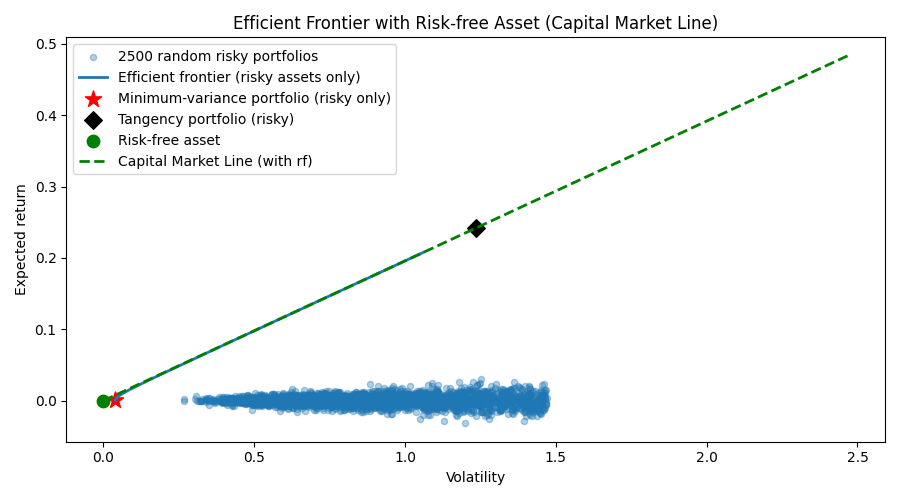

In [10]:
# ================================
# 8) EFFICIENT FRONTIER WITH A RISK-FREE ASSET
# ================================

# Risk-free rate (same units as mu: daily if ANNUALIZE=False, annual if ANNUALIZE=True)
rf = 0.0001  # example: 0.01% per day; adjust as needed

ones = np.ones_like(mu)
excess = mu - rf * ones   # μ - rf * 1

# (μ - rf1)' Σ^{-1} (μ - rf1)
kappa = float(excess @ Theta @ excess)
if kappa <= 0:
    raise ValueError("kappa <= 0: (μ - rf1)' Σ⁻¹ (μ - rf1) must be positive.")

def min_var_with_rf(p, rf, excess, Theta):
    """
    For a target expected return p > rf, compute the minimized variance (and vol)
    of the optimal risky portfolio satisfying:
        min (1/2) w' Σ w
        s.t. rf + w' μ = p
    using the closed-form:
        σ²_min = (p - rf)² / [(μ - rf1)' Σ⁻¹ (μ - rf1)].
    """
    kappa = float(excess @ Theta @ excess)
    if kappa <= 0:
        raise ValueError("kappa <= 0 in min_var_with_rf.")
    var = (p - rf) ** 2 / kappa
    var = max(var, 0.0)
    return var, np.sqrt(var)

# Tangency portfolio (risky part) – proportional to Σ⁻¹ (μ - rf1)
w_tan_unscaled = Theta @ excess       # Σ⁻¹ (μ - rf1)
sum_w_tan = w_tan_unscaled.sum()
if np.isclose(sum_w_tan, 0.0):
    raise ValueError("Cannot normalize tangency portfolio: sum of weights is ~0.")

w_tan = w_tan_unscaled / sum_w_tan    # scaled so that 1'w* = 1

# Portfolio statistics of the tangency portfolio
ret_tan, vol_tan = portfolio_stats(w_tan, mu, Sigma)

print("Risk-free rate rf       =", rf)
print("Tangency portfolio mean =", ret_tan)
print("Tangency portfolio vol  =", vol_tan)

# Capital Market Line (CML): combinations of rf and tangency portfolio
# p(σ) = rf + ( (μ_tan - rf)/σ_tan ) * σ
max_vol_candidates = [rp_vols.max(), sigma_eff.max(), vol_tan * 2.0]
max_vol_cml = max(v for v in max_vol_candidates if np.isfinite(v))

sigma_cml = np.linspace(0.0, max_vol_cml, 200)
p_cml = rf + (ret_tan - rf) * (sigma_cml / vol_tan)  # straight line through (0, rf) and (σ_tan, μ_tan)

# ================================
# 9) PLOT: RISKY FRONTIER + CML
# ================================

fig, ax = plt.subplots(figsize=(9, 5))

# Random portfolios (risky only)
ax.scatter(
    rp_vols,
    rp_rets,
    s=20,
    alpha=0.35,
    label=f"{len(rp_vols)} random risky portfolios"
)

# Original efficient frontier (risky assets only)
ax.plot(
    sigma_eff,
    p_eff,
    lw=2.0,
    label="Efficient frontier (risky assets only)"
)

# Minimum-variance portfolio (risky only)
ax.scatter(
    [vol_mv],
    [ret_mv],
    marker="*",
    s=150,
    color="red",
    label="Minimum-variance portfolio (risky only)"
)

# Tangency portfolio point
ax.scatter(
    [vol_tan],
    [ret_tan],
    marker="D",
    s=80,
    color="black",
    label="Tangency portfolio (risky)"
)

# Risk-free point
ax.scatter(
    [0.0],
    [rf],
    marker="o",
    s=80,
    color="green",
    label="Risk-free asset"
)

# Capital Market Line
ax.plot(
    sigma_cml,
    p_cml,
    lw=2.0,
    linestyle="--",
    color="green",
    label="Capital Market Line (with rf)"
)

x_label = "Volatility"
y_label = "Expected return"
if ANNUALIZE:
    x_label += " (annualized)"
    y_label += " (annualized)"

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title("Efficient Frontier with Risk-free Asset (Capital Market Line)")
ax.legend(loc="best")
plt.tight_layout()
plt.show()


In [11]:
# ================================
# 10) DISPLAY TANGENCY PORTFOLIO WEIGHTS
# ================================

w_tan_series = pd.Series(w_tan, index=tickers).sort_values(ascending=False)

print("Top 10 weights in the tangency portfolio (risky part only):")
print(w_tan_series.head(10))
print("\nSum of tangency weights (risky assets) =", w_tan_series.sum())
print("Tangency portfolio expected return     =", ret_tan)
print("Tangency portfolio volatility          =", vol_tan)
print("Risk-free rate                         =", rf)


Top 10 weights in the tangency portfolio (risky part only):
Ticker
KIK.MU       1.178864
NR7.F        0.241552
MSTR         0.033294
RHM.DE       0.032335
GLE.PA       0.020851
HEI.DE       0.020515
ESLT         0.020376
TPL          0.020228
SAAB-B.ST    0.019852
TELIA1.HE    0.017941
dtype: float64

Sum of tangency weights (risky assets) = 1.0000000000000004
Tangency portfolio expected return     = 0.2416783064636271
Tangency portfolio volatility          = 1.233921127428933
Risk-free rate                         = 0.0001
